In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from tqdm import tqdm
from PIL import Image

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch.nn.functional as F
from torchvision import models


## Utils

In [142]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='binary'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)
            ax.set_ylabel('Percentage')
            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

def occlusion_sensitivity_mask(model, image, patch_size=50):
    """
    Perform occlusion sensitivity analysis with mask sliding over a given image.
    
    Parameters:
    - model: Trained model.
    - image: Preprocessed input image tensor (1, C, H, W).
    - patch_size: Size of the patch to keep.
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    model.eval()  # Set the model to evaluation mode
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    # Move the image tensor to the correct device
    device = next(model.parameters()).device
    image = image.to(device)
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            # Create a masked image
            occluded_image = torch.zeros_like(image)  # Mask initialized with zeros (full occlusion)
            i_end = min(i + patch_size, img_height)
            j_end = min(j + patch_size, img_width)
            occluded_image[:, :, i:i_end, j:j_end] = image[:, :, i:i_end, j:j_end]
            
            # Predict the output for the occluded patch
            with torch.no_grad():
                output = model(occluded_image)
                score = torch.sigmoid(output).item()
            
            # Record the score in the heatmap
            heatmap[i:i_end, j:j_end] = score
            # print(score)
    
    return heatmap

def plot_test_images_with_labels(X_test, y_test, predictions=[], probabilities=[], num_images=10, index=0, only_wrong = False, probability = False):
    """
    Plots test images with their true and predicted labels.
    
    Parameters:
    - X_test: Array of test images.
    - y_test: Array of true labels for the test images.
    - predictions: Array of predicted labels for the test images.
    - num_images: Number of images to plot. Default is 10.
    """
    # Ensure num_images doesn't exceed the number of test images
    num_images = min(num_images, len(X_test))
    
    # Create a figure with a grid of subplots
    plt.figure(figsize=(20, 10))
    i = -1
    plotted = 0
    if probability == False:
        while plotted < num_images:
            i+=1
            if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                continue
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = 'War related' if predictions[i+index] == 1 else 'Non war related'
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index}')
        index = index+i+1
    else:   
        while plotted < num_images:
            i+=1
            if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                continue
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = float(probabilities[i+index])
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nProb: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index+1}')
        index = index+i+1

    plt.tight_layout()
    plt.show()
    return index
    
    
# Function to visualise class imbalance over batchers
def visualise_dataloader(dl):
    total_num_images = len(dl.dataset)
    class_0_batch_counts = []
    class_1_batch_counts = []

    graph_df = pd.DataFrame({
        'batch_num':[],
        'class_0':[],
        'class_1':[]
    })

    for i, batch in enumerate(dl):
        
        labels = batch[1].tolist()
        unique_labels = set(labels)
        if len(unique_labels) > 2:
            raise ValueError("More than two classes detected")
        
        class_0_count = labels.count(0)
        class_1_count = labels.count(1)

        class_0_batch_counts.append(class_0_count)
        class_1_batch_counts.append(class_1_count)
        
        graph_df.loc[len(graph_df)] = [i+1, class_0_count, class_1_count]
    
    plt.figure(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Plotting bars for class_1
    plt.bar(graph_df['batch_num'], graph_df['class_1'], bar_width, label='Class 1')

    # Plotting bars for class_0
    plt.bar(graph_df['batch_num'] + bar_width, graph_df['class_0'], bar_width, label='Class 0')

    # Adding labels and title
    plt.xlabel('Batch Number')
    plt.ylabel('Number of Images')
    plt.title('Number of Class 1 and Class 0 for Each Batch Number')
    plt.legend()

    plt.tight_layout()
    plt.show()        

# Convert images back to standard size
def denormalize(image_numpy, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image_numpy = (image_numpy * std + mean)
    return image_numpy

def reverse_transform(image_numpy):
    # Define mean and std used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalize
    image_numpy = denormalize(image_numpy, mean, std)
    
    # Clip the values to be in the range [0, 1]
    image_numpy = np.clip(image_numpy, 0, 1)
    
    # Convert to PIL image
    #'image_pil = Image.fromarray((image_numpy * 255).astype(np.uint8))
    
    return image_numpy

def evaluate_model_with_images(model, dataloader, threshold=0.5, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'softmax':
                # Softmax
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
            elif activation == 'sigmoid':
                # Sigmodid
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
    
    # Reverse transformations for all images
    denormalized_images = [reverse_transform(image.transpose(1, 2, 0)) for image in all_images]
    
    return denormalized_images, all_labels, all_probs

def evaluate_model(model, dataloader, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_probs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'sigmoid':
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            elif activation == 'softmax':
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_probs

# Find the optimal threshold for F1 score
def find_best_threshold(y_true, probs):
    best_f1 = 0
    best_threshold = 0

    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        predictions = [1 if prob >= threshold else 0 for prob in probs]
        f1 = f1_score(y_true, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def occlusion_sensitivity(model, image, label, patch_size=50, baseline=0):
    """
    Perform occlusion sensitivity analysis on a given image.
    
    Parameters:
    - model: Trained model.
    - image: Input image.
    - label: True label of the input image.
    - patch_size: Size of the patch to occlude.
    - baseline: Baseline value for occlusion (default is 0).
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            occluded_image = image.copy()
            occluded_image[i:i+patch_size, j:j+patch_size, :] = baseline
            
            # Predict the output for the occluded image
            occluded_image = np.expand_dims(occluded_image, axis=0)
            preds = model.predict(occluded_image)
            class_score = preds[0, label]  # Score for the true class
            
            # Record the change in the heatmap
            heatmap[i:i+patch_size, j:j+patch_size] = class_score
    
    return heatmap

def occlusion_sensitivity_mask(model, image, patch_size=50):
    """
    Perform occlusion sensitivity analysis with mask sliding over a given image.
    
    Parameters:
    - model: Trained model.
    - image: Preprocessed input image tensor (1, C, H, W).
    - patch_size: Size of the patch to keep.
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    model.eval()  # Set the model to evaluation mode
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    # Move the image tensor to the correct device
    device = next(model.parameters()).device
    image = image.to(device)
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            # Create a masked image
            occluded_image = torch.zeros_like(image)  # Mask initialized with zeros (full occlusion)
            i_end = min(i + patch_size, img_height)
            j_end = min(j + patch_size, img_width)
            occluded_image[:, :, i:i_end, j:j_end] = image[:, :, i:i_end, j:j_end]
            
            # Predict the output for the occluded patch
            with torch.no_grad():
                output = model(occluded_image)
                score = torch.sigmoid(output).item()
            
            # Record the score in the heatmap
            heatmap[i:i_end, j:j_end] = score
            # print(score)
    
    return heatmap


## Load the data

In [ ]:
# Data Loader

## Load the model

In [ ]:
# Loading model

## Test predictions

In [71]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)
val_images, val_labels, val_probs = evaluate_model_with_images(trained_model, val_loader, device=device)

# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(val_labels, val_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

Evaluating: 100%|██████████| 25/25 [00:37<00:00,  1.52s/batch]


Best Threshold: 0.64


Plotting the computed metrics

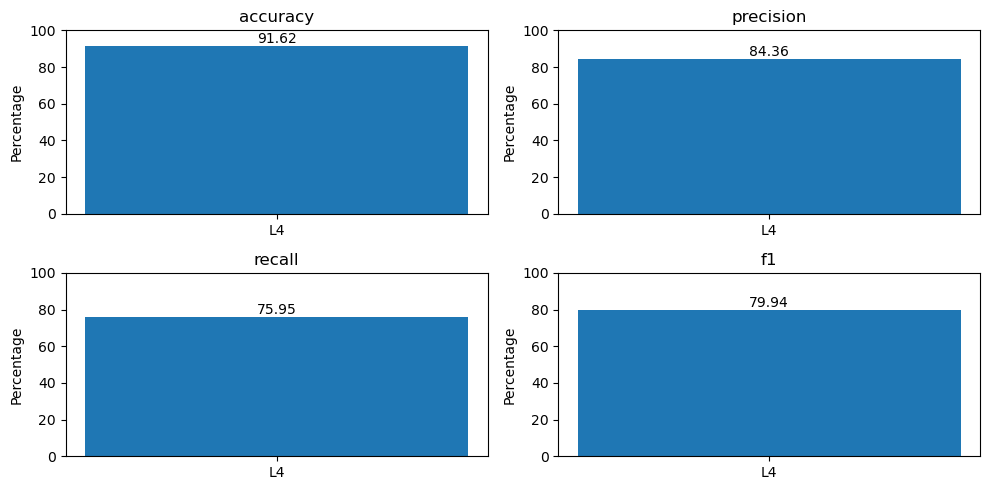

In [72]:
metrics = Metrics()
metrics.run(test_labels, test_preds, "ResNet50")
metrics.plot()

# Confusion Matrix

In [ ]:
# Counfusion Matrix

## Analysis of False Positives

In [ ]:
# False positive images

## Analysis of False Negatives

In [ ]:
# False Negative images

In [67]:
index=0

## Feature Importance

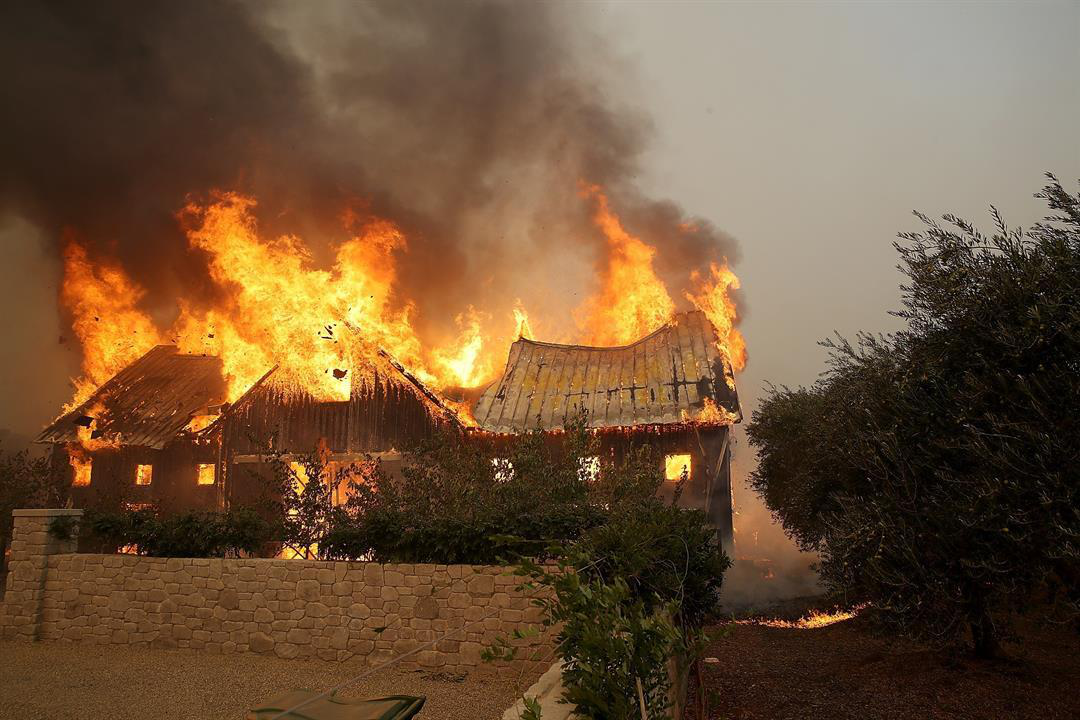

In [146]:
# Load and display the image
# image_path = '/Users/user/Desktop/backupThesis/Thesis_model/all_images/military/_80403227_025499461-1.jpg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/all_frames/frame_atres_noche_2023-02-02_sec_1165.jpg'
# image_path = '/Users/user/Downloads/WhatsApp Image 2024-06-13 at 15.35.23.jpeg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_120.jpg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_1181.jpg'
image_path = '/Users/user/Desktop/backupThesis/Thesis_model/all_images/fire_images/917794892113498113_0.jpg'
image = Image.open(image_path)
image
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [147]:
# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [148]:
# Set the model to evaluation mode
resnet50.eval()

# Move the image tensor to the same device as the model
image_tensor = image_tensor.to(device)

# Get the prediction
with torch.no_grad():
    output = resnet50(image_tensor)
    probability = torch.sigmoid(output).item()

# Convert the probability to a binary prediction
prediction = 1 if probability > 0.5 else 0

# Print the prediction
labels = {0: 'Not war', 1: 'War'}
print(f"Predicted class: '{labels[prediction]}' with probability of war being: {probability:.4f}")

Predicted class: 'War' with probability of war being: 1.0000


In [ ]:
# Define the same transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

label = prediction

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Plot the transformed image
transformed_image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to HWC
transformed_image = transformed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
transformed_image = np.clip(transformed_image, 0, 1)  # Clip to valid range

### Occlusion Sensitivity

In [ ]:
# Perform occlusion sensitivity analysis
resnet50.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity(resnet50, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()

### Occlusion Sensitivity (Reverse)

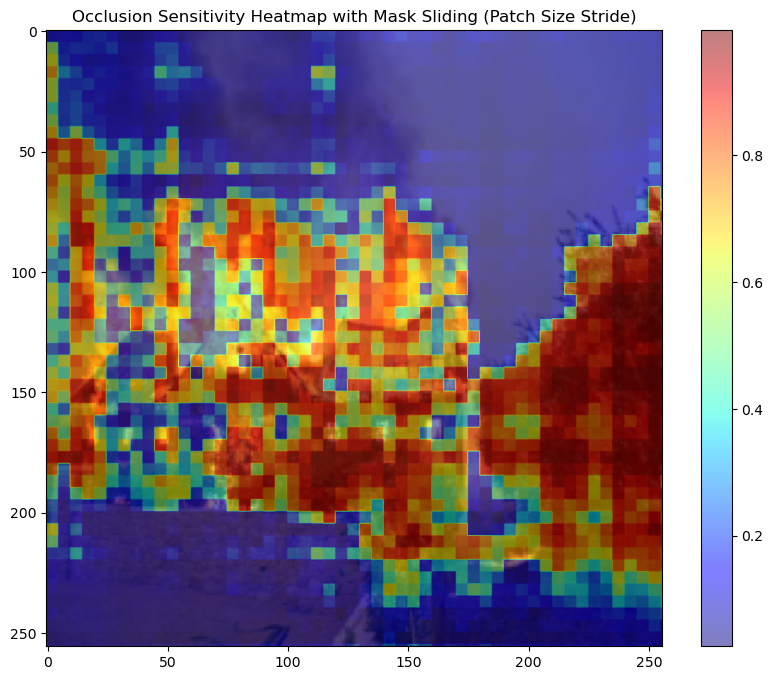

In [149]:
# Perform occlusion sensitivity analysis
resnet50.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity_mask(resnet50, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()